In [1]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import skimage as ski
import ydf
from rasterio.features import shapes
from skimage.exposure import rescale_intensity
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split
from ydf import RandomForestLearner

In [2]:
# Data location
sample_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Sample_GEDI_v1.geojson"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"
lc_sample_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Sample_LC_v1.geojson"

In [3]:
# Load sample
sample = gpd.read_file(sample_dir)

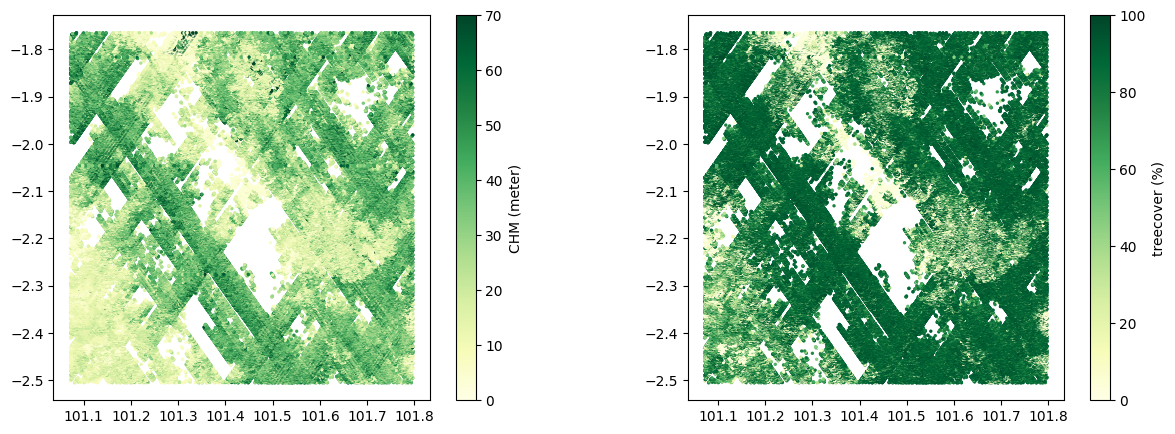

In [4]:
# GEDI Data parameter
gedi_props = [
    {"name": "CHM", "unit": "meter", "min": 0, "max": 70},
    {"name": "treecover", "unit": "%", "min": 0, "max": 100},
]

plt.figure(figsize=(15, 5))

# Visualize sample
for x in range(len(gedi_props)):
    dict_gedi = gedi_props[x]
    name = dict_gedi["name"]
    unit = dict_gedi["unit"]
    min = dict_gedi["min"]
    max = dict_gedi["max"]

    ax = plt.subplot(1, 2, x + 1)
    sample.plot(
        column=name,
        cmap="YlGn",
        markersize=2,
        legend=True,
        vmin=min,
        vmax=max,
        legend_kwds={"label": f"{name} ({unit})"},
        ax=ax,
    )

sample_extract = sample.copy()
coords = [coord for coord in zip(sample_extract.geometry.x, sample_extract.geometry.y)]

C:\Users\ramiq\AppData\Local\Temp\ipykernel_15424\1408078545.py:57: RuntimeWarning: divide by zero encountered in divide
  index = (band1_image - band2_image) / (band1_image + band2_image)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_15424\1408078545.py:57: RuntimeWarning: divide by zero encountered in divide
  index = (band1_image - band2_image) / (band1_image + band2_image)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_15424\1408078545.py:57: RuntimeWarning: divide by zero encountered in divide
  index = (band1_image - band2_image) / (band1_image + band2_image)


id        CHM  treecover                    geometry  COASTAL  \
0            0  21.570000  79.583597  POINT (101.78126 -1.81583)   0.0140   
1            1  36.820000  83.417898  POINT (101.79114 -1.81583)   0.0155   
2            2  43.369999  90.923297  POINT (101.77452 -1.81561)   0.0143   
3            3  57.869999  91.172498  POINT (101.78081 -1.81538)   0.0139   
4            4  34.380001  86.333001  POINT (101.79069 -1.81538)   0.0158   
...        ...        ...        ...                         ...      ...   
220483  220483  64.320000  94.916499   POINT (101.3961 -2.27599)   0.0134   
220484  220484  42.580000  90.350550  POINT (101.40621 -2.27599)   0.0182   
220485  220485  35.000000  89.628202   POINT (101.4125 -2.27599)   0.0129   
220486  220486  38.080002  82.567102  POINT (101.41609 -2.27599)   0.0161   
220487  220487  55.700001  84.231198   POINT (101.4482 -2.27599)   0.0130   

          BLUE   GREEN     RED     NIR   SWIR1  ...      WV      NDMI  \
0       0.0176  0.0372  0.0222  0.3318  0.1375  ...  0.0028  0.414021   
1       0.0192  0.0348  0.0197  0.2832  0.1185  ...  0.0015  0.410007   
2       0.0172  0.0392  0.0207  0.3020  0.1274  ...  0.0034  0.406614   
3       0.0171  0.0338  0.0211  0.2879  0.1162  ...  0.0038  0.424895   
4       0.0183  0.0381  0.0198  0.3261  0.1350  ...  0.0012  0.414444   
...        ...     ...     ...     ...     ...  ...     ...       ...   
220483  0.0184  0.0346  0.0248  0.2261  0.1249  ...  0.0015  0.288319   
220484  0.0211  0.0366  0.0238  0.2727  0.1324  ...  0.0014  0.346334   
220485  0.0169  0.0334  0.0251  0.2086  0.1137  ...  0.0027  0.294446   
220486  0.0188  0.0389  0.0246  0.2664  0.1226  ...  0.0041  0.369666   
220487  0.0188  0.0381  0.0246  0.2870  0.1329  ...  0.0017  0.366992   

             NBR      NBR2      NDWI     MNDWI    MNDWI2     HH      HV  \
0       0.728575  0.450422 -0.798374 -0.574127 -0.166853 -6.052 -10.132   
1       0.743306  0.479401 -0.781132 -0.545988 -0.090196 -8.490 -12.415   
2       0.713475  0.432265 -0.770223 -0.529412 -0.125975 -7.083 -11.438   
3       0.724468  0.432799 -0.789866 -0.549333 -0.152882 -8.710 -12.762   
4       0.749464  0.485966 -0.790774 -0.559792 -0.101415 -7.890 -12.063   
...          ...       ...       ...       ...       ...    ...     ...   
220483  0.600708  0.377827 -0.734561 -0.566144 -0.239560 -8.730 -12.553   
220484  0.662298  0.410011 -0.763337 -0.566864 -0.204348 -6.276 -10.800   
220485  0.608947  0.383212 -0.723967 -0.545887 -0.205707 -6.469 -10.499   
220486  0.663441  0.389235 -0.745169 -0.518266 -0.161638 -7.323 -12.116   
220487  0.673957  0.407839 -0.765611 -0.554386 -0.189362 -6.637 -11.065   

             RVI  
0      -0.252101  
1      -0.187754  
2      -0.235138  
3      -0.188711  
4      -0.209141  
...          ...  
220483 -0.179627  
220484 -0.264933  
220485 -0.237506  
220486 -0.246566  
220487 -0.250141  

[220488 rows x 21 columns]

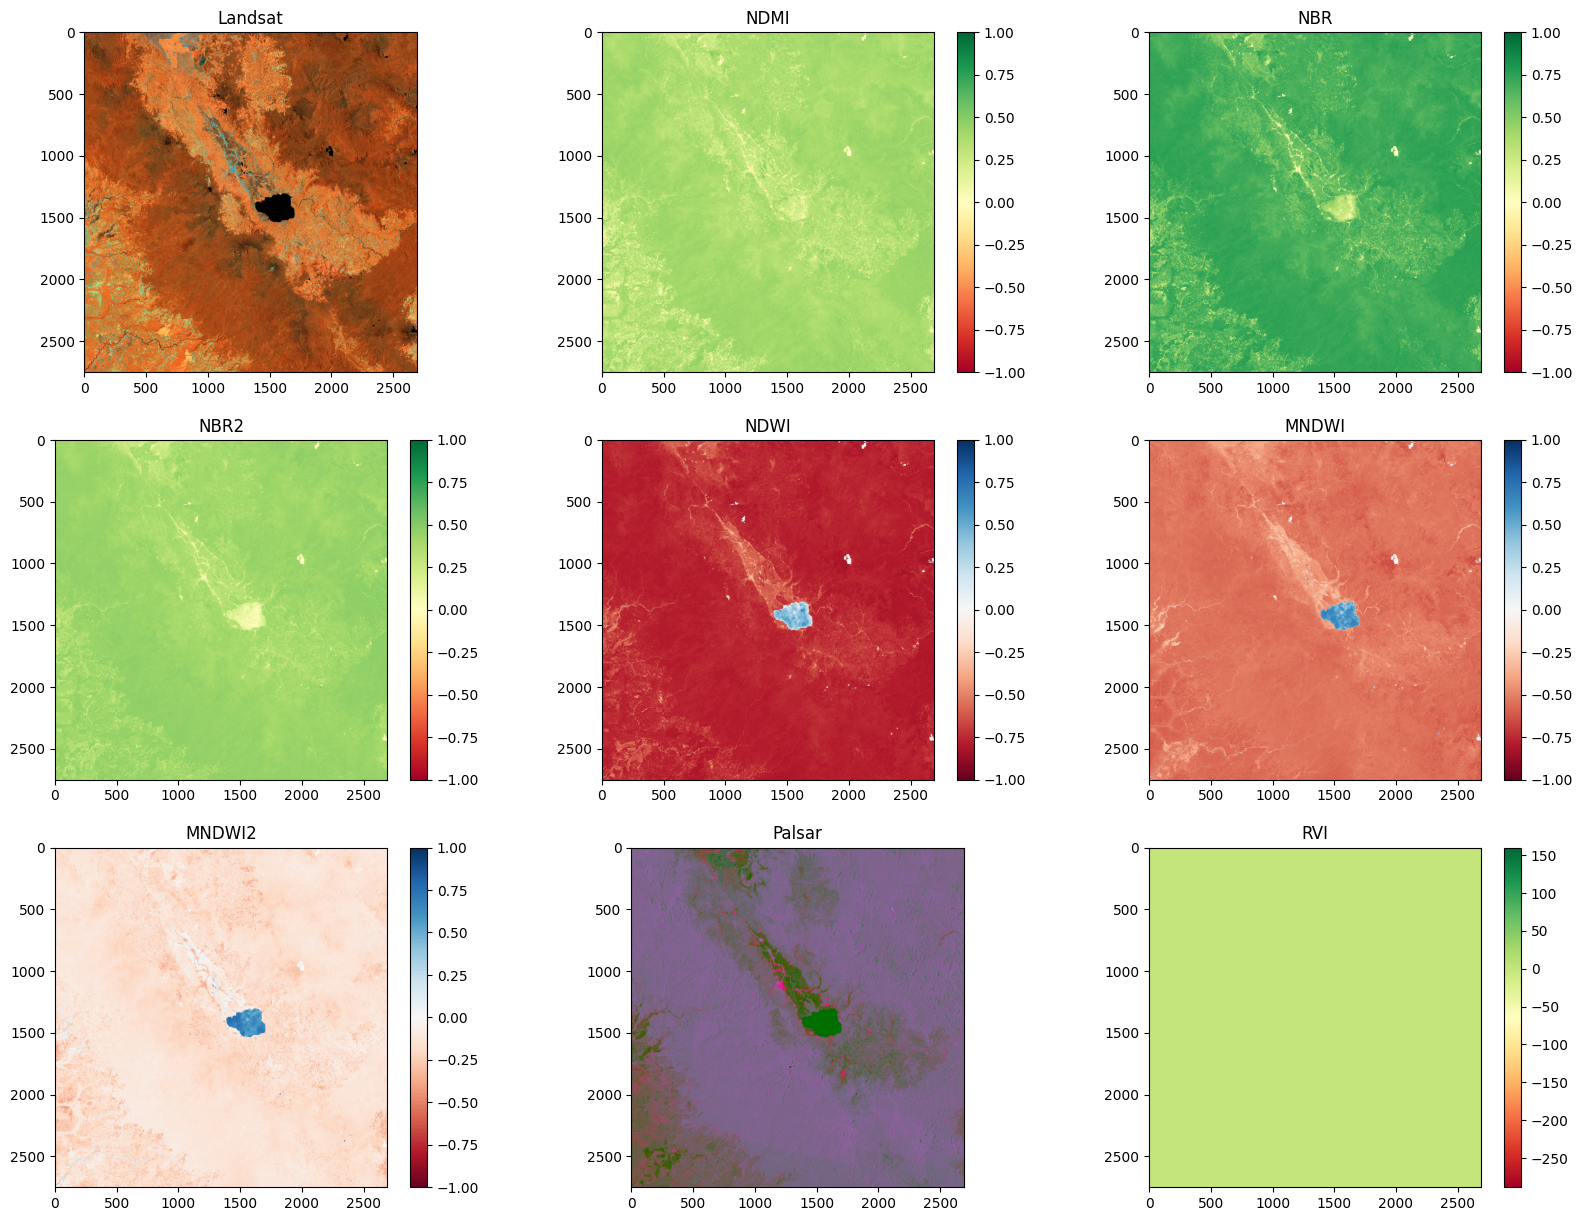

In [5]:
# Load data, plot, and extract

plt.figure(figsize=(20, 15))

# Indices list
indices_landsat = [
    dict(name="NDMI", band1="NIR", band2="SWIR1", cmap="RdYlGn"),
    dict(name="NBR", band1="NIR", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NBR2", band1="SWIR1", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NDWI", band1="GREEN", band2="NIR", cmap="RdBu"),
    dict(name="MNDWI", band1="GREEN", band2="SWIR1", cmap="RdBu"),
    dict(name="MNDWI2", band1="GREEN", band2="SWIR2", cmap="RdBu"),
]
band_landsat = ["COASTAL", "BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2", "WV"]
band_map_landsat = dict(
    COASTAL=0, BLUE=1, GREEN=2, RED=3, NIR=4, SWIR1=5, SWIR2=6, WV=7
)

# Load landsat data
with rio.open(landsat_dir) as landsat:
    landsat_shape = landsat.shape

    landsat_image = landsat.read() / 1e4

    # False color composite
    out_range = (0, 1)
    red = rescale_intensity(landsat_image[4], in_range=(0.1, 0.4), out_range=out_range)
    green = rescale_intensity(
        landsat_image[5], in_range=(0.05, 0.3), out_range=out_range
    )
    blue = rescale_intensity(
        landsat_image[6], in_range=(0.025, 0.25), out_range=out_range
    )

    composite_landsat = np.dstack([red, green, blue])

    # Plot landsat image
    plt.subplot(3, 3, 1)
    plt.title("Landsat")
    plt.imshow(composite_landsat)

    # Sample landsat
    # Extract sample
    sample_extract[band_landsat] = [x for x in landsat.sample(coords)]

    # Plot indices
    landsat_indices_images = []
    for x in range(len(indices_landsat)):
        props = indices_landsat[x]
        name = props["name"]
        band1 = props["band1"]
        band2 = props["band2"]
        band1_image = landsat_image[band_map_landsat[band1]]
        band2_image = landsat_image[band_map_landsat[band2]]

        # Calculate index
        index = (band1_image - band2_image) / (band1_image + band2_image)

        # Add the image into stack
        landsat_indices_images.append(index)

        # Plot index image
        plt.subplot(3, 3, 2 + x)
        plt.title(name)
        plt.imshow(index, cmap=props["cmap"], vmin=-1, vmax=1)
        plt.colorbar()

        # Generate indices sample
        sample_extract[name] = (sample_extract[band1] - sample_extract[band2]) / (
            sample_extract[band1] + sample_extract[band2]
        )

    landsat_indices_images = np.stack(landsat_indices_images)


# Load palsar image
band_sar = ["HH", "HV"]
with rio.open(palsar_dir) as palsar:
    palsar_image = (
        palsar.read(
            out_shape=landsat_shape,
        )
        / 1e3
    )

    hh = palsar_image[0]
    hv = palsar_image[1]
    rvi = (hh - hv) / (hh + hv)

    red = rescale_intensity(hh, in_range=(-15, 0), out_range=out_range)
    green = rescale_intensity(rvi, in_range=(-1, 1), out_range=out_range)
    blue = rescale_intensity(hv, in_range=(-20, -5), out_range=out_range)
    composite_sar = np.dstack([red, green, blue])

    # Plot palsar image
    plt.subplot(3, 3, 8)
    plt.title("Palsar")
    plt.imshow(composite_sar)

    plt.subplot(3, 3, 9)
    plt.title("RVI")
    plt.imshow(rvi, cmap="RdYlGn")
    plt.colorbar()

    # Extract sample
    sample_extract[band_sar] = [x for x in palsar.sample(coords)]
    sample_extract["RVI"] = (sample_extract["HH"] - sample_extract["HV"]) / (
        sample_extract["HH"] + sample_extract["HV"]
    )

# Filter sample
sample_extract = sample_extract[
    (sample_extract["BLUE"] != -9999) | (sample_extract["HH"] != -9999)
]

# Rescale data
sample_extract[band_landsat] = sample_extract[band_landsat] / 1e4
sample_extract[band_sar] = sample_extract[band_sar] / 1e3

sample_extract

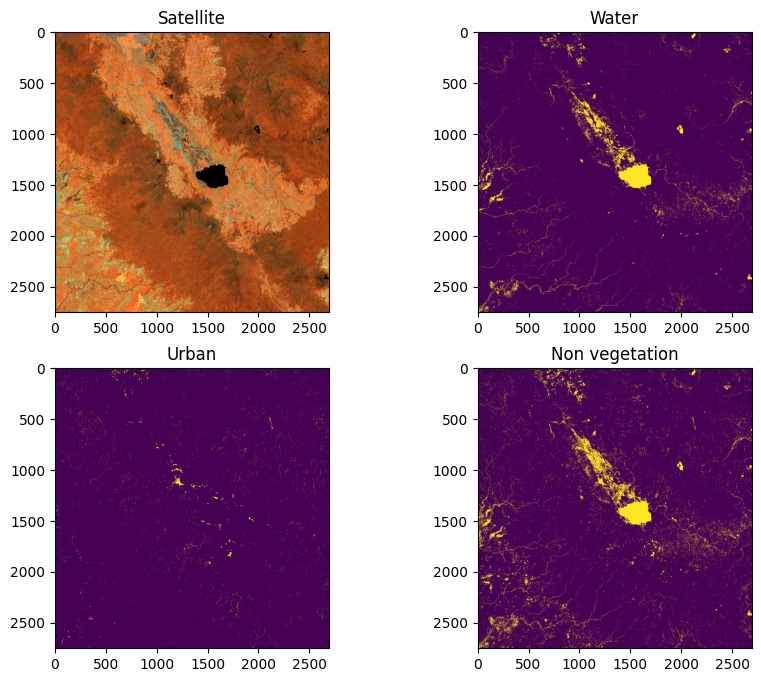

In [6]:
# Create mask image
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Satellite")
plt.imshow(composite_landsat)

mndwi = landsat_indices_images[4]
ndwi = landsat_indices_images[3]
mndwi2 = landsat_indices_images[5]
ndmi = landsat_indices_images[0]

water_image = (mndwi > -0.1) | (ndwi > -0.1) | (hh < -15) | (mndwi2 > -0.05)
plt.subplot(2, 2, 2)
plt.title("Water")
plt.imshow(water_image)

urban_image = hh > -5
plt.subplot(2, 2, 3)
plt.title("Urban")
plt.imshow(urban_image)

non_vegetation = (ndmi < 0.1) | water_image | urban_image
plt.subplot(2, 2, 4)
plt.title("Non vegetation")
plt.imshow(non_vegetation)

In [7]:
# Filter sample that is likely forest
sample_forest = sample_extract.copy()
sample_forest = sample_forest[
    (sample_forest["NDMI"] > 0.1)
    & (sample_forest["NDWI"] < -0.1)
    & (sample_forest["MNDWI"] < -0.1)
    & (sample_forest["MNDWI2"] < -0.05)
    & (sample_forest["HH"] > -15)
    & (sample_forest["HH"] < -5)
]
sample_forest

id        CHM  treecover                    geometry  COASTAL  \
0            0  21.570000  79.583597  POINT (101.78126 -1.81583)   0.0140   
1            1  36.820000  83.417898  POINT (101.79114 -1.81583)   0.0155   
2            2  43.369999  90.923297  POINT (101.77452 -1.81561)   0.0143   
3            3  57.869999  91.172498  POINT (101.78081 -1.81538)   0.0139   
4            4  34.380001  86.333001  POINT (101.79069 -1.81538)   0.0158   
...        ...        ...        ...                         ...      ...   
220483  220483  64.320000  94.916499   POINT (101.3961 -2.27599)   0.0134   
220484  220484  42.580000  90.350550  POINT (101.40621 -2.27599)   0.0182   
220485  220485  35.000000  89.628202   POINT (101.4125 -2.27599)   0.0129   
220486  220486  38.080002  82.567102  POINT (101.41609 -2.27599)   0.0161   
220487  220487  55.700001  84.231198   POINT (101.4482 -2.27599)   0.0130   

          BLUE   GREEN     RED     NIR   SWIR1  ...      WV      NDMI  \
0       0.0176  0.0372  0.0222  0.3318  0.1375  ...  0.0028  0.414021   
1       0.0192  0.0348  0.0197  0.2832  0.1185  ...  0.0015  0.410007   
2       0.0172  0.0392  0.0207  0.3020  0.1274  ...  0.0034  0.406614   
3       0.0171  0.0338  0.0211  0.2879  0.1162  ...  0.0038  0.424895   
4       0.0183  0.0381  0.0198  0.3261  0.1350  ...  0.0012  0.414444   
...        ...     ...     ...     ...     ...  ...     ...       ...   
220483  0.0184  0.0346  0.0248  0.2261  0.1249  ...  0.0015  0.288319   
220484  0.0211  0.0366  0.0238  0.2727  0.1324  ...  0.0014  0.346334   
220485  0.0169  0.0334  0.0251  0.2086  0.1137  ...  0.0027  0.294446   
220486  0.0188  0.0389  0.0246  0.2664  0.1226  ...  0.0041  0.369666   
220487  0.0188  0.0381  0.0246  0.2870  0.1329  ...  0.0017  0.366992   

             NBR      NBR2      NDWI     MNDWI    MNDWI2     HH      HV  \
0       0.728575  0.450422 -0.798374 -0.574127 -0.166853 -6.052 -10.132   
1       0.743306  0.479401 -0.781132 -0.545988 -0.090196 -8.490 -12.415   
2       0.713475  0.432265 -0.770223 -0.529412 -0.125975 -7.083 -11.438   
3       0.724468  0.432799 -0.789866 -0.549333 -0.152882 -8.710 -12.762   
4       0.749464  0.485966 -0.790774 -0.559792 -0.101415 -7.890 -12.063   
...          ...       ...       ...       ...       ...    ...     ...   
220483  0.600708  0.377827 -0.734561 -0.566144 -0.239560 -8.730 -12.553   
220484  0.662298  0.410011 -0.763337 -0.566864 -0.204348 -6.276 -10.800   
220485  0.608947  0.383212 -0.723967 -0.545887 -0.205707 -6.469 -10.499   
220486  0.663441  0.389235 -0.745169 -0.518266 -0.161638 -7.323 -12.116   
220487  0.673957  0.407839 -0.765611 -0.554386 -0.189362 -6.637 -11.065   

             RVI  
0      -0.252101  
1      -0.187754  
2      -0.235138  
3      -0.188711  
4      -0.209141  
...          ...  
220483 -0.179627  
220484 -0.264933  
220485 -0.237506  
220486 -0.246566  
220487 -0.250141  

[212085 rows x 21 columns]

In [8]:
# Outlier tolerance
outlier_multiplier = 4

# Sample filter by outlier
sample_normal = sample_forest.copy()

# Filter sample based on std deviation
for dict in gedi_props:
    name = dict["name"]
    sample_normal = sample_normal[sample_normal[name] > 0]
    mean = np.mean(sample_normal[name])
    stddev = np.std(sample_normal[name])
    sample_normal = sample_normal[
        sample_normal[name] > (mean - (stddev * outlier_multiplier))
    ]
    sample_normal = sample_normal[
        sample_normal[name] < (mean + (stddev * outlier_multiplier))
    ]

sample_normal

id        CHM  treecover                    geometry  COASTAL  \
0            0  21.570000  79.583597  POINT (101.78126 -1.81583)   0.0140   
1            1  36.820000  83.417898  POINT (101.79114 -1.81583)   0.0155   
2            2  43.369999  90.923297  POINT (101.77452 -1.81561)   0.0143   
3            3  57.869999  91.172498  POINT (101.78081 -1.81538)   0.0139   
4            4  34.380001  86.333001  POINT (101.79069 -1.81538)   0.0158   
...        ...        ...        ...                         ...      ...   
220483  220483  64.320000  94.916499   POINT (101.3961 -2.27599)   0.0134   
220484  220484  42.580000  90.350550  POINT (101.40621 -2.27599)   0.0182   
220485  220485  35.000000  89.628202   POINT (101.4125 -2.27599)   0.0129   
220486  220486  38.080002  82.567102  POINT (101.41609 -2.27599)   0.0161   
220487  220487  55.700001  84.231198   POINT (101.4482 -2.27599)   0.0130   

          BLUE   GREEN     RED     NIR   SWIR1  ...      WV      NDMI  \
0       0.0176  0.0372  0.0222  0.3318  0.1375  ...  0.0028  0.414021   
1       0.0192  0.0348  0.0197  0.2832  0.1185  ...  0.0015  0.410007   
2       0.0172  0.0392  0.0207  0.3020  0.1274  ...  0.0034  0.406614   
3       0.0171  0.0338  0.0211  0.2879  0.1162  ...  0.0038  0.424895   
4       0.0183  0.0381  0.0198  0.3261  0.1350  ...  0.0012  0.414444   
...        ...     ...     ...     ...     ...  ...     ...       ...   
220483  0.0184  0.0346  0.0248  0.2261  0.1249  ...  0.0015  0.288319   
220484  0.0211  0.0366  0.0238  0.2727  0.1324  ...  0.0014  0.346334   
220485  0.0169  0.0334  0.0251  0.2086  0.1137  ...  0.0027  0.294446   
220486  0.0188  0.0389  0.0246  0.2664  0.1226  ...  0.0041  0.369666   
220487  0.0188  0.0381  0.0246  0.2870  0.1329  ...  0.0017  0.366992   

             NBR      NBR2      NDWI     MNDWI    MNDWI2     HH      HV  \
0       0.728575  0.450422 -0.798374 -0.574127 -0.166853 -6.052 -10.132   
1       0.743306  0.479401 -0.781132 -0.545988 -0.090196 -8.490 -12.415   
2       0.713475  0.432265 -0.770223 -0.529412 -0.125975 -7.083 -11.438   
3       0.724468  0.432799 -0.789866 -0.549333 -0.152882 -8.710 -12.762   
4       0.749464  0.485966 -0.790774 -0.559792 -0.101415 -7.890 -12.063   
...          ...       ...       ...       ...       ...    ...     ...   
220483  0.600708  0.377827 -0.734561 -0.566144 -0.239560 -8.730 -12.553   
220484  0.662298  0.410011 -0.763337 -0.566864 -0.204348 -6.276 -10.800   
220485  0.608947  0.383212 -0.723967 -0.545887 -0.205707 -6.469 -10.499   
220486  0.663441  0.389235 -0.745169 -0.518266 -0.161638 -7.323 -12.116   
220487  0.673957  0.407839 -0.765611 -0.554386 -0.189362 -6.637 -11.065   

             RVI  
0      -0.252101  
1      -0.187754  
2      -0.235138  
3      -0.188711  
4      -0.209141  
...          ...  
220483 -0.179627  
220484 -0.264933  
220485 -0.237506  
220486 -0.246566  
220487 -0.250141  

[211981 rows x 21 columns]

In [9]:
# Split sample to train and test
train, test = train_test_split(
    sample_normal, train_size=0.8, random_state=1, shuffle=True
)
print(f"Train size: {len(train)}\nTest size: {len(test)}")

Train size: 169584
Test size: 42397


Best predictors CHM: ['GREEN', 'SWIR1', 'SWIR2', 'RED', 'BLUE', 'COASTAL']
Train model on 169584 examples
Model trained in 0:00:30.067664
Best predictors treecover: ['GREEN', 'SWIR2', 'RED', 'SWIR1', 'BLUE', 'HV']
Train model on 169584 examples
Model trained in 0:00:30.153465


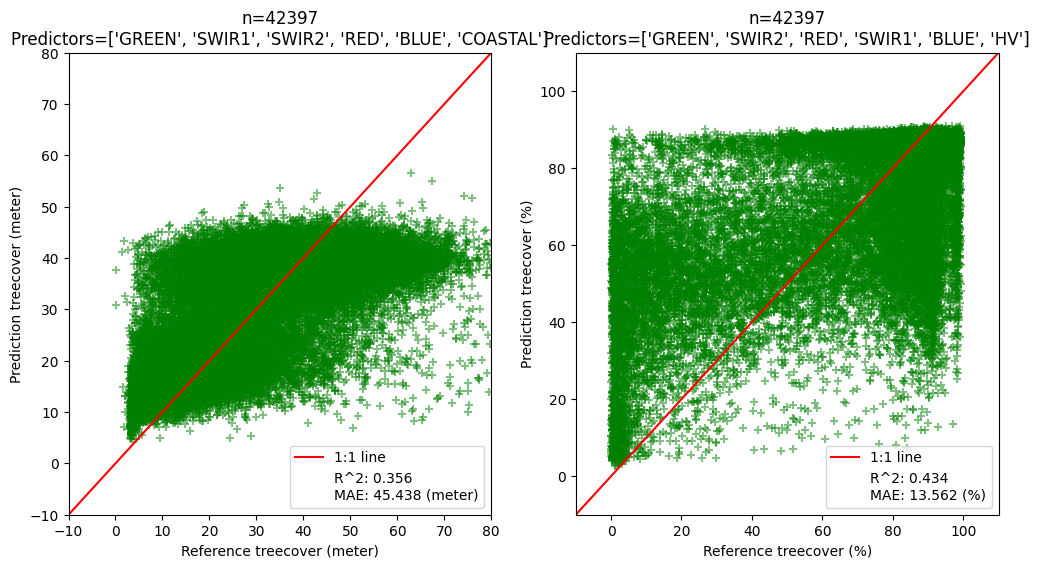

In [10]:
# Make random forest model
predictors = list(sample_normal.columns[4:])

plt.figure(figsize=(12, 6))

# Make for model for each of the GEDI data type
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    label = dict["name"]
    unit = dict["unit"]
    min = dict["min"]
    max = dict["max"]
    unit = dict["unit"]

    corrs = []
    for band in predictors:
        r2 = np.corrcoef(sample_normal[label], sample_normal[band])[0][1] ** 2
        corrs.append({"band": band, "r2": r2})

    corrs.sort(key=lambda x: x["r2"], reverse=True)
    best = list(map(lambda x: x["band"], corrs[:6]))
    print(f"Best predictors {label}: {best}")

    model = RandomForestLearner(
        num_trees=300,
        max_depth=-1,
        label=label,
        features=best,
        task=ydf.Task.REGRESSION,
    )
    model = model.train(train)

    # Test model
    test_apply = model.predict(test)

    # R2
    r2 = round(np.corrcoef(test[name], test_apply)[0][1] ** 2, 3)

    # MAE
    mae = round(mean_absolute_error(test[name], test_apply), 3)

    # 1:1 plot
    plt.subplot(1, 2, x + 1)
    plt.title(f"n={len(test)}\nPredictors={best}")
    plt.plot([min - 10, max + 10], [min - 10, max + 10], label="1:1 line", color="r")
    plt.scatter(test[label], test_apply, color="green", marker="+", alpha=0.5)
    plt.plot([], [], label=f"R^2: {r2}\nMAE: {mae} ({unit})", color="#00000000")
    plt.xlabel(f"Reference {name} ({unit})")
    plt.ylabel(f"Prediction {name} ({unit})")
    plt.xlim(min - 10, max + 10)
    plt.ylim(min - 10, max + 10)
    plt.legend(loc="lower right")

    gedi_props[x]["model"] = model
    gedi_props[x]["predictors"] = best
    gedi_props[x]["R2"] = r2
    gedi_props[x]["MAE"] = mae

In [11]:
# Prepare image
combine_image = np.concatenate(
    (landsat_image, landsat_indices_images, palsar_image, [rvi]), 0
)
image_transpose = combine_image.transpose(1, 2, 0)
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=predictors,
)
table_image

COASTAL    BLUE   GREEN     RED     NIR   SWIR1   SWIR2      WV  \
0         0.0151  0.0165  0.0329  0.0213  0.2570  0.1103  0.0428  0.0023   
1         0.0164  0.0178  0.0352  0.0220  0.2583  0.1113  0.0438  0.0025   
2         0.0165  0.0185  0.0381  0.0231  0.2780  0.1226  0.0471  0.0026   
3         0.0185  0.0210  0.0431  0.0256  0.3570  0.1471  0.0557  0.0024   
4         0.0187  0.0225  0.0415  0.0264  0.3451  0.1447  0.0571  0.0023   
...          ...     ...     ...     ...     ...     ...     ...     ...   
7405687   0.0129  0.0164  0.0394  0.0244  0.2644  0.1202  0.0478  0.0024   
7405688   0.0125  0.0164  0.0390  0.0244  0.2775  0.1247  0.0491  0.0024   
7405689   0.0116  0.0156  0.0375  0.0230  0.2791  0.1199  0.0456  0.0027   
7405690   0.0109  0.0149  0.0350  0.0218  0.2549  0.1089  0.0423  0.0027   
7405691   0.0110  0.0146  0.0331  0.0205  0.2601  0.1142  0.0434  0.0026   

             NDMI       NBR      NBR2      NDWI     MNDWI    MNDWI2     HH  \
0        0.399401  0.714476  0.440888 -0.773025 -0.540503 -0.130779 -7.825   
1        0.397727  0.710030  0.435203 -0.760136 -0.519454 -0.108861 -8.132   
2        0.387918  0.710243  0.444903 -0.758937 -0.525825 -0.105634 -7.620   
3        0.416386  0.730070  0.450690 -0.784554 -0.546793 -0.127530 -7.376   
4        0.409147  0.716062  0.434093 -0.785308 -0.554243 -0.158215 -7.012   
...           ...       ...       ...       ...       ...       ...    ...   
7405687  0.374935  0.693786  0.430952 -0.740619 -0.506266 -0.096330 -7.649   
7405688  0.379910  0.699326  0.434983 -0.753555 -0.523519 -0.114642 -7.523   
7405689  0.398997  0.719125  0.448943 -0.763108 -0.523507 -0.097473 -6.921   
7405690  0.401319  0.715343  0.440476 -0.758537 -0.513551 -0.094437 -6.918   
7405691  0.389794  0.714003  0.449239 -0.774216 -0.550577 -0.134641 -7.098   

             HV       RVI  
0       -12.033 -0.211905  
1       -12.049 -0.194093  
2       -11.556 -0.205257  
3       -11.608 -0.222925  
4       -11.223 -0.230930  
...         ...       ...  
7405687 -11.563 -0.203727  
7405688 -11.695 -0.217088  
7405689 -11.679 -0.255806  
7405690 -11.240 -0.238022  
7405691 -11.118 -0.220685  

[7405692 rows x 17 columns]

In [12]:
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    model = dict["model"]
    name = dict["name"]
    predictors = dict["predictors"]

    print(f"Predicting {name}")

    # Apply to image
    prediction = model.predict(table_image)

    gedi_props[x]["prediction"] = prediction

Predicting CHM
Predicting treecover


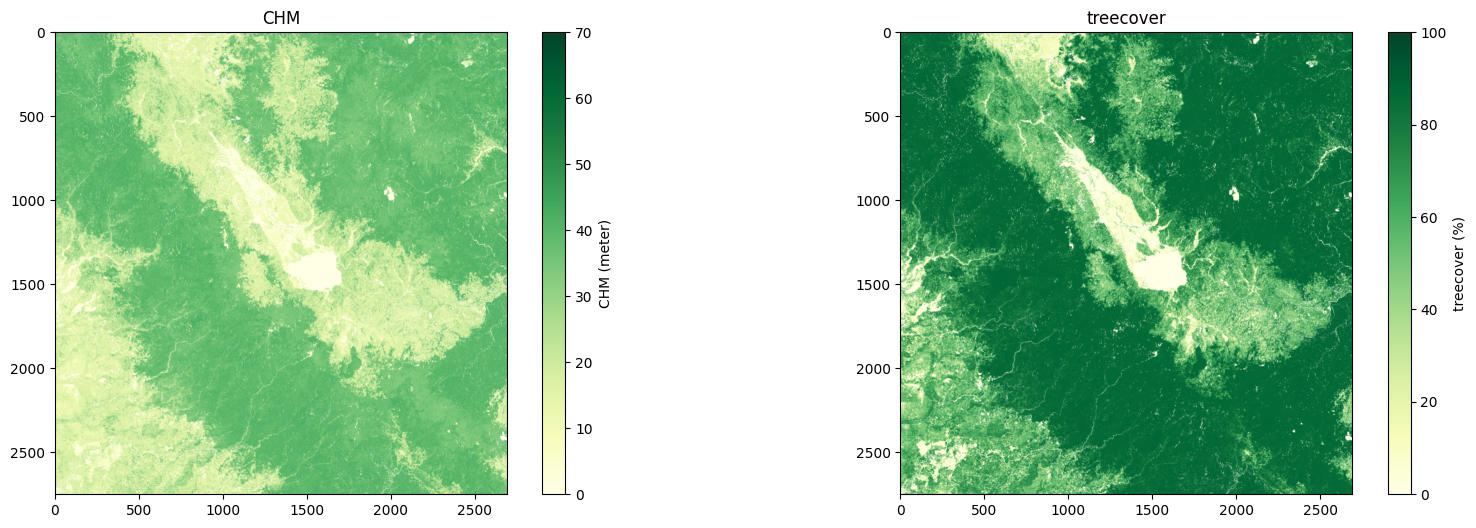

In [13]:
# Show to plot
plt.figure(figsize=(20, 6))

# Show the plot again
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    model = dict["model"]
    name = dict["name"]
    min = dict["min"]
    max = dict["max"]
    unit = dict["unit"]
    prediction = dict["prediction"]

    # Prediction to image again
    prediction_image = prediction.reshape(transpose_shape[0], transpose_shape[1])
    prediction_image[non_vegetation] = 0
    gedi_props[x]["prediction_masked"] = prediction_image

    plt.subplot(1, 2, x + 1)
    plt.imshow(
        prediction_image, cmap="YlGn", interpolation="bilinear", vmin=min, vmax=max
    )
    plt.colorbar(label=f"{name} ({unit})")
    plt.title(name)

In [14]:
# Forest structure
chm = gedi_props[0]["prediction_masked"]
treecover = gedi_props[1]["prediction_masked"]
forest_structure_raw = np.stack([chm, treecover])

# Save image to geotiff
with rio.open(landsat_dir) as source:
    with rio.open(
        "forest_data.tif",
        "w",
        "COG",
        count=forest_structure_raw.shape[0],
        width=forest_structure_raw.shape[2],
        height=forest_structure_raw.shape[1],
        crs=source.crs,
        transform=source.transform,
        dtype="uint8",
        nodata=255,
        compress="lzw",
        resampling="bilinear",
    ) as output:
        output.write(forest_structure_raw)
        output.descriptions = ("CHM", "treecover")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


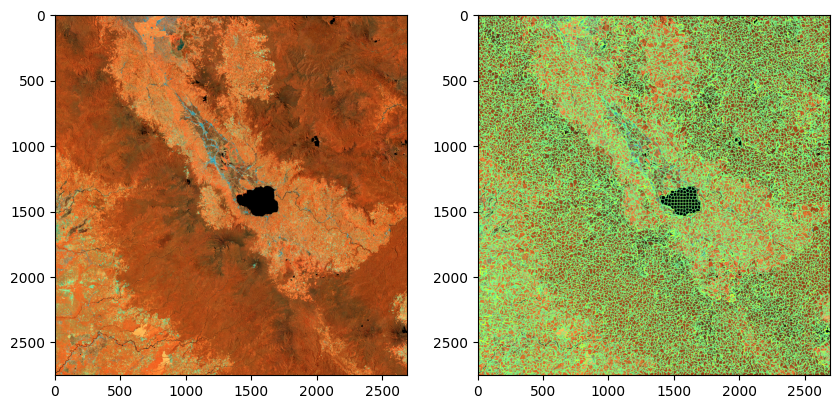

In [15]:
# Generate segmentation

# Do uniform filter to composite image
seed_image = composite_landsat
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(seed_image)

# Segmentation
segment = ski.segmentation.slic(seed_image, n_segments=15000, compactness=2, sigma=3)
plt.subplot(1, 2, 2)
plt.imshow(
    ski.segmentation.mark_boundaries(
        composite_landsat, segment, outline_color=(0, 255, 255)
    )
)

In [16]:
# Get the mode of each segment
segment_unique = np.unique(segment)
chm_segment = segment.copy()
treecover_segment = segment.copy()
for x in segment_unique:
    chm_segment[segment == x] = np.mean(chm[segment == x])
    treecover_segment[segment == x] = np.mean(treecover[segment == x])

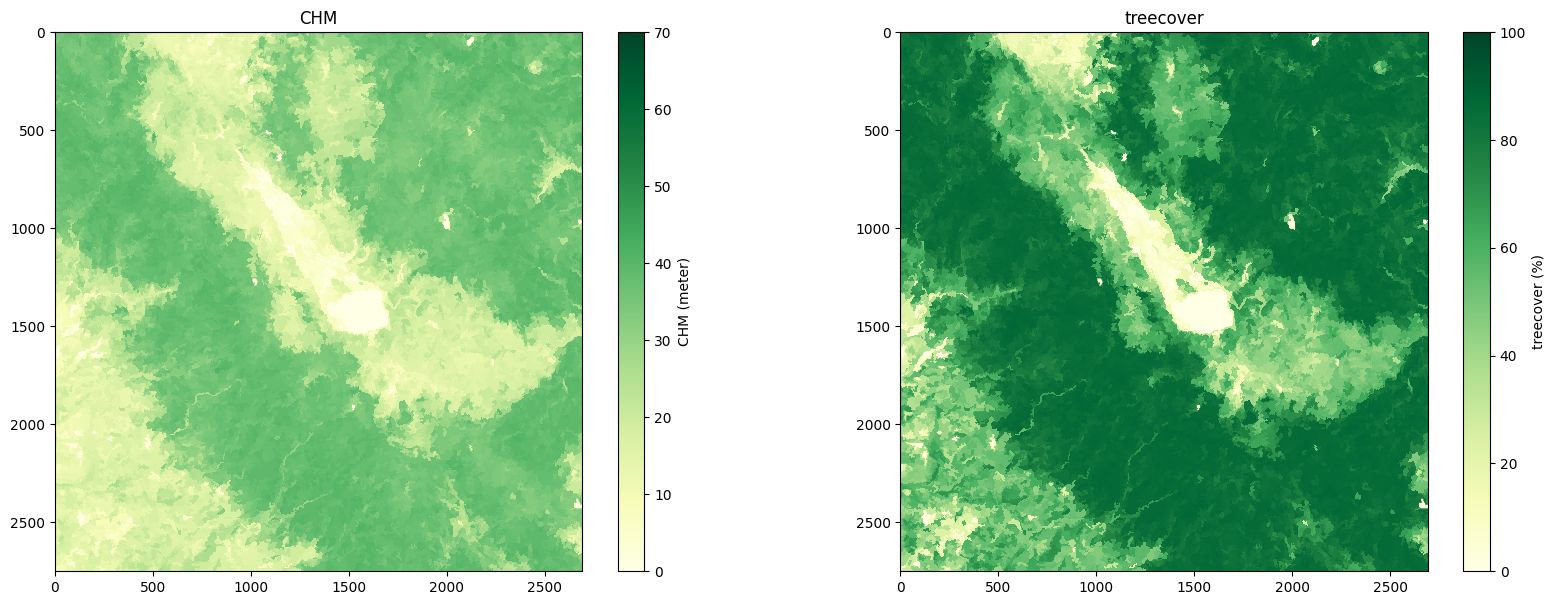

In [17]:
# Show segmented data
gedi_props[0]["segmented"] = chm_segment
gedi_props[1]["segmented"] = treecover_segment

plt.figure(figsize=(20, 7))
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    model = dict["model"]
    name = dict["name"]
    min = dict["min"]
    max = dict["max"]
    unit = dict["unit"]
    segmented = dict["segmented"]

    plt.subplot(1, 2, x + 1)
    plt.imshow(segmented, cmap="YlGn", interpolation="nearest", vmin=min, vmax=max)
    plt.colorbar(label=f"{name} ({unit})")
    plt.title(name)

In [18]:
# Forest classificaiton
chm = gedi_props[0]["segmented"]
treecover = gedi_props[1]["segmented"]

# Saved as tif
forest_data = np.stack([chm, treecover])

# Save image to geotiff
with rio.open(landsat_dir) as source:
    with rio.open(
        "forest_data_segmented.tif",
        "w",
        "COG",
        count=forest_data.shape[0],
        width=forest_data.shape[2],
        height=forest_data.shape[1],
        crs=source.crs,
        transform=source.transform,
        dtype="uint8",
        nodata=255,
        compress="lzw",
        resampling="bilinear",
        tiled=True,
    ) as output:
        output.write(forest_data)
        output.descriptions = ("CHM", "treecover")

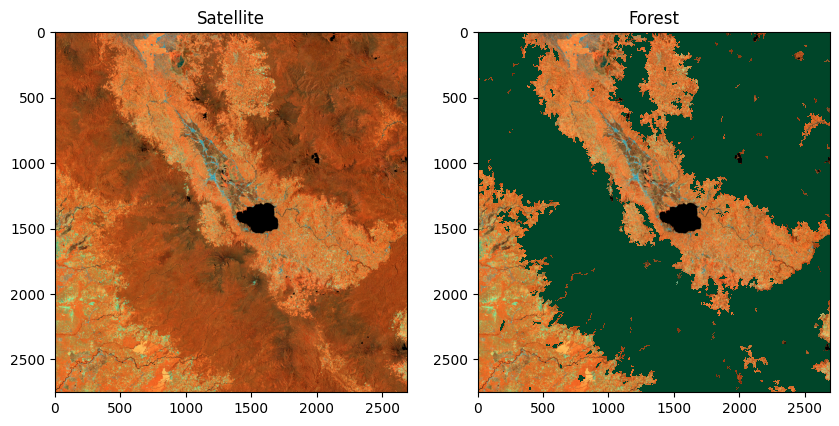

In [19]:
# Make forest mask
forest_mask = (chm > 15) & (treecover > 70)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Satellite")
plt.imshow(composite_landsat)

plt.subplot(1, 2, 2)
plt.title("Forest")
plt.imshow(composite_landsat)
plt.imshow(
    np.ma.masked_where(forest_mask == 0, forest_mask),
    cmap="YlGn",
    vmin=0,
    vmax=1,
    interpolation="nearest",
)

In [20]:
# Get sample of land cover to get primary and secondary forest
sample_lc = gpd.read_file(lc_sample_dir, driver="GeoJSON")
sample_lc

c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


id     lc                    geometry
0          0   2001  POINT (101.67155 -1.86099)
1          1   2001  POINT (101.43871 -2.23694)
2          2   2001  POINT (101.49341 -1.77152)
3          3   2001  POINT (101.75132 -2.02161)
4          4   2001   POINT (101.1242 -1.96125)
...      ...    ...                         ...
14024  14024  50011  POINT (101.32983 -1.83297)
14025  14025  50011  POINT (101.33306 -1.82461)
14026  14026  50011   POINT (101.33064 -1.8362)
14027  14027  50011  POINT (101.30207 -1.80063)
14028  14028  50011   POINT (101.32363 -1.8362)

[14029 rows x 3 columns]

In [21]:
# Only take the forest class
sample_lc_forest_primary = sample_lc[
    (sample_lc["lc"] == 2001) | (sample_lc["lc"] == 2004) | (sample_lc["lc"] == 2005)
]
sample_lc_forest_primary["forest"] = 2
sample_lc_forest_primary["label"] = "Primary forest"
sample_lc_forest_secondary = sample_lc[
    (sample_lc["lc"] == 2002) | (sample_lc["lc"] == 20041) | (sample_lc["lc"] == 20051)
]
sample_lc_forest_secondary["forest"] = 1
sample_lc_forest_secondary["label"] = "Secondary forest"
sample_lc_non_forest = sample_lc[
    ((sample_lc["lc"] >= 2006) & (sample_lc["lc"] <= 5001)) | (sample_lc["lc"] >= 20071)
]
sample_lc_non_forest["forest"] = 0
sample_lc_non_forest["label"] = "Non forest"
sample_lc_forest = pd.concat([sample_lc_forest_primary, sample_lc_forest_secondary])
sample_lc_forest

c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be s

id    lc                    geometry  forest             label
0        0  2001  POINT (101.67155 -1.86099)       2    Primary forest
1        1  2001  POINT (101.43871 -2.23694)       2    Primary forest
2        2  2001  POINT (101.49341 -1.77152)       2    Primary forest
3        3  2001  POINT (101.75132 -2.02161)       2    Primary forest
4        4  2001   POINT (101.1242 -1.96125)       2    Primary forest
...    ...   ...                         ...     ...               ...
1995  1995  2002   POINT (101.4829 -2.20891)       1  Secondary forest
1996  1996  2002  POINT (101.16598 -1.82812)       1  Secondary forest
1997  1997  2002   POINT (101.56402 -2.3415)       1  Secondary forest
1998  1998  2002  POINT (101.37483 -1.78257)       1  Secondary forest
1999  1999  2002  POINT (101.21341 -2.31159)       1  Secondary forest

[2000 rows x 5 columns]

In [22]:
# Extract raster value using sample
sample_lc_forest_extract = sample_lc_forest.copy()
coords = [
    (x, y)
    for x, y in zip(
        sample_lc_forest_extract["geometry"].x, sample_lc_forest_extract["geometry"].y
    )
]
with rio.open("forest_data_segmented.tif") as forest_data_source:
    sample_lc_forest_extract[["CHM", "treecover"]] = np.stack(
        [x for x in forest_data_source.sample(coords)]
    )

# Only use sample that is forest
sample_lc_forest_extract = sample_lc_forest_extract[
    (sample_lc_forest_extract["CHM"] > 15)
    & (sample_lc_forest_extract["treecover"] > 70)
]

sample_lc_forest_extract

id    lc                    geometry  forest             label  CHM  \
0        0  2001  POINT (101.67155 -1.86099)       2    Primary forest   38   
2        2  2001  POINT (101.49341 -1.77152)       2    Primary forest   36   
3        3  2001  POINT (101.75132 -2.02161)       2    Primary forest   34   
4        4  2001   POINT (101.1242 -1.96125)       2    Primary forest   38   
5        5  2001  POINT (101.66266 -2.37735)       2    Primary forest   35   
...    ...   ...                         ...     ...               ...  ...   
1992  1992  2002  POINT (101.46619 -2.21026)       1  Secondary forest   33   
1993  1993  2002  POINT (101.08594 -2.04398)       1  Secondary forest   33   
1996  1996  2002  POINT (101.16598 -1.82812)       1  Secondary forest   35   
1998  1998  2002  POINT (101.37483 -1.78257)       1  Secondary forest   28   
1999  1999  2002  POINT (101.21341 -2.31159)       1  Secondary forest   31   

      treecover  
0            85  
2            85  
3            78  
4            84  
5            86  
...         ...  
1992         80  
1993         82  
1996         81  
1998         72  
1999         78  

[1721 rows x 7 columns]

Train model on 1376 examples
Model trained in 0:00:00.235036
              precision    recall  f1-score   support

           1       0.79      0.60      0.68       155
           2       0.73      0.87      0.79       190

    accuracy                           0.75       345
   macro avg       0.76      0.73      0.74       345
weighted avg       0.75      0.75      0.74       345



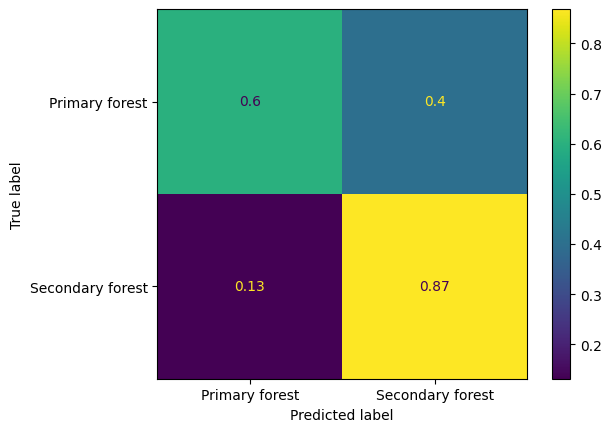

In [ ]:
# Label and predictors
label_forest = "forest"
predictors_forest = ["CHM", "treecover"]

# Split sample to train and test
forest_train, forest_test = train_test_split(
    sample_lc_forest_extract, train_size=0.8, random_state=1, shuffle=True
)

# Run classification using Random Forest
model_forest = RandomForestLearner(
    num_trees=1000,
    max_depth=-1,
    label=label_forest,
    features=predictors_forest,
    task=ydf.Task.CLASSIFICATION,
)
model_forest = model_forest.train(forest_train)

# Test
test_forest_apply = model_forest.predict(forest_test)
test_forest_apply_class = test_forest_apply.copy()
test_forest_apply_class[test_forest_apply < 0.5] = 2
test_forest_apply_class[test_forest_apply >= 0.5] = 1
test_forest_apply_class = test_forest_apply_class.astype("uint8")
cm_forest = confusion_matrix(
    forest_test[label_forest], test_forest_apply_class, normalize="true"
)
ConfusionMatrixDisplay(cm_forest).plot()
plt.xticks([0, 1], ["Primary forest", "Secondary forest"])
plt.yticks([0, 1], ["Primary forest", "Secondary forest"])
print(classification_report(forest_test[label_forest], test_forest_apply_class))

In [52]:
# Apply to the image
forest_features = np.stack([chm_segment, treecover_segment])
forest_features_transpose = forest_features.transpose(1, 2, 0)
forest_transpose_shape = forest_features_transpose.shape
forest_table = pd.DataFrame(
    forest_features_transpose.reshape(-1, forest_transpose_shape[2]),
    columns=predictors_forest,
)
forest_classification = model_forest.predict(forest_table)
forest_classification_class = forest_classification.copy()
forest_classification_class[forest_classification < 0.5] = 2
forest_classification_class[forest_classification >= 0.5] = 1
forest_classification_class = forest_classification_class.astype("uint8")

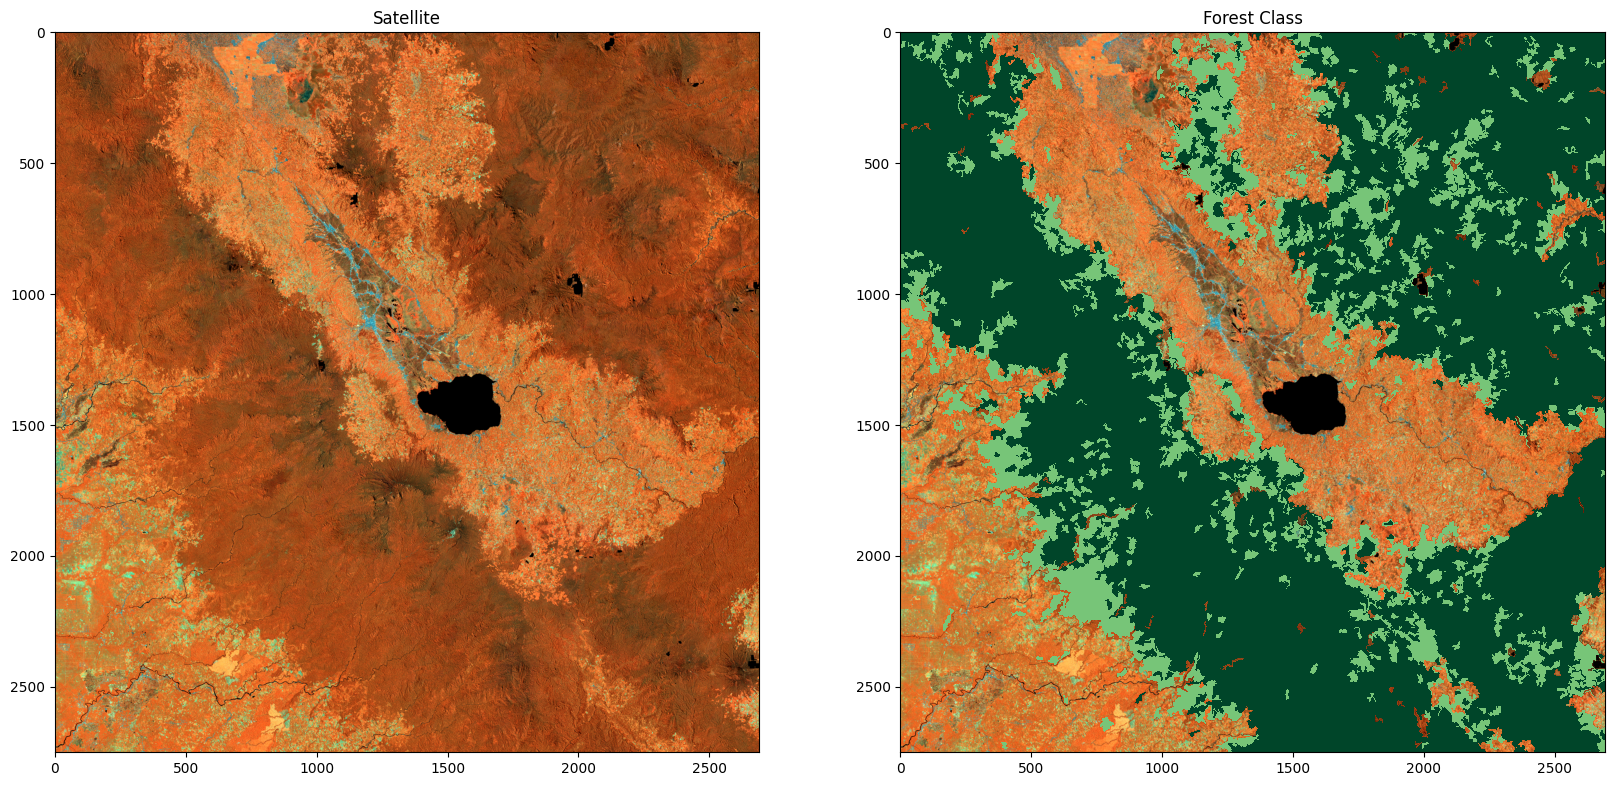

In [54]:
# Show the result of forest classification
# Prediction to image again
forest_classification_image = forest_classification_class.reshape(
    forest_transpose_shape[0], forest_transpose_shape[1]
)
forest_classification_image[forest_mask == 0] = 0

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Satellite")
plt.imshow(composite_landsat)

plt.subplot(1, 2, 2)
plt.title("Forest Class")
plt.imshow(composite_landsat)
plt.imshow(
    np.ma.masked_where(forest_classification_image == 0, forest_classification_image),
    cmap="YlGn",
    vmin=0,
    vmax=2,
    interpolation="nearest",
)

In [56]:
# Save forest to geotiff
with rio.open(landsat_dir) as source:
    with rio.open(
        "forest_class.tif",
        "w",
        "COG",
        count=1,
        width=forest_classification_image.shape[1],
        height=forest_classification_image.shape[0],
        crs=source.crs,
        transform=source.transform,
        dtype="uint8",
        nodata=0,
        compress="lzw",
        resampling="nearest",
    ) as output:
        output.write_colormap(1, {0: (255, 255, 224), 1: (0, 128, 0), 2: (0, 100, 0)})
        output.write(forest_classification_image, 1)
        output.descriptions = tuple(["forest_class"])

c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


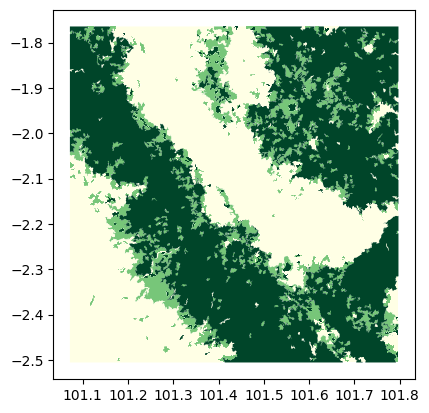

In [58]:
# Convert raster to shapefile
with rio.open(landsat_dir) as source:
    forest_vector = [
        {"type": "Feature", "properties": {"forest": x[1]}, "geometry": x[0]}
        for x in shapes(
            forest_classification_image.astype("uint8"), transform=source.transform
        )
    ]
    forest_vector = json.dumps(
        {"type": "FeatureCollection", "properties": {}, "features": forest_vector}
    )

    # Read as geodataframe
    forest_df = gpd.read_file(forest_vector, driver="GeoJSON")

    # Plot it
    forest_df.plot(column="forest", cmap="YlGn")

In [59]:
# Add another column such as palette and label
forest_df["palette"] = forest_df["forest"].map(
    {0: "FFFFE0", 1: "#008000", 2: "#006400"}
)
forest_df["label"] = forest_df["forest"].map(
    {0: "Non forest", 1: "Secondary forest", 2: "Primary forest"}
)

# Save the file
forest_df.to_file("Forest_Shapefile.shp")